# Робота №4. Вивчення структури металів за допомогою функції радіального розподілу атомів

## Мета роботи
Дослідження параметрів структури металів в кристалічному та рідкому стані за допомогою визначення ФРР атомів моделюванням методом молекулярної динаміки.

## Об'єкт дослідження
Чисті метали за умов різних температур.

## Устаткування, прилади та матеріали

In [58]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Latex
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.signal import find_peaks_cwt

def read_xyz(name):
    data_frame = pd.read_csv(name, delimiter='\s+', skipinitialspace=True, skiprows=4,
                             names=['skip1', 'HETATM', 'type', 'X', 'Y', 'Z'])[['X', 'Y', 'Z']]
    data_frame.dropna(inplace=True)
    return data_frame

def read_rdf(name):
    data_frame = pd.read_csv(name, delimiter='\s+', skipinitialspace=True, skiprows=1,
                             names=['X', 'count', 'cummulative'], index_col='X')
    return data_frame

## Програма проведення експерименту
Створити кристал з ~1000-2000 атомів з періодичними граничними умовами. Матеріал: Pt.

In [30]:
Rostyslav Bohomaz%%writefile in.xm
read ../pot/Pt_xmd.eam

box 8 8 8

fill particle 4
1     0.0        0.0        0.0
1     0.5        0.0        0.5
1     0.5        0.5        0.0
1     0.0        0.5        0.5

fill align 8 8 8
fill orient 1 0 0  0 1 0  0 0 1
fill go

dtime 1e-14

select all #
mass 195.084

calc T=200

clamp off
itemp T
scale 3.9231

select index 1457
set add 1
select keep on

# експеримент при T=0.1*T_пл
cmd 1000
write pdb ./out/exp_0.pdb
WRITE file ./out/exp_0.rdf RDF 100 2 7

# експеримент при T=1.5*T_пл
repeat 99
    itemp T
    cmd 200
    calc T=T+30
    write file +./out/exp_1.temp TEMP
end

write pdb ./out/exp_1.pdb

Overwriting in.xm


Задаємо температуру плавлення Pt, та розрахункових температур:

In [2]:
Tmelt = 2041.4 # Kelvin
T = [round(temp, -2) for temp in [0.1*Tmelt, 1.5*Tmelt]]

Релаксовуємо матеріал при температурах 0.1 і 1.5T<sub>пл</sub>.

In [31]:
!xmd in.xm > exp.log

Зчитуємо координати атомів:

In [32]:
xyz = [read_xyz(f'./out/exp_{i}.pdb') for i in range(2)]
rdf = [read_rdf(f'./out/exp_{i}.rdf') for i in range(2)]

## Опрацювання результатів експерименту

- Розрахувати нові координати атомів, використовуючи положення обраного атома
поблизу центру розрахункової комірки за початок координат.

In [33]:
for i in range(2):
    centre = xyz[i].iloc[1456]
    for axis in ['X', 'Y', 'Z']:
        xyz[i][axis] = xyz[i][axis] - centre[axis]
    xyz[i]['distance'] = np.sqrt(xyz[i].X ** 2 + xyz[i].Y ** 2 + xyz[i].Z **2)

Побудувати гістограму розподілу атомів за відстанню до 7 А з інтервалом 0,1 А для
температур T=0,1 і 1,5T<sub>пл</sub>, виходячи з координат атомів.

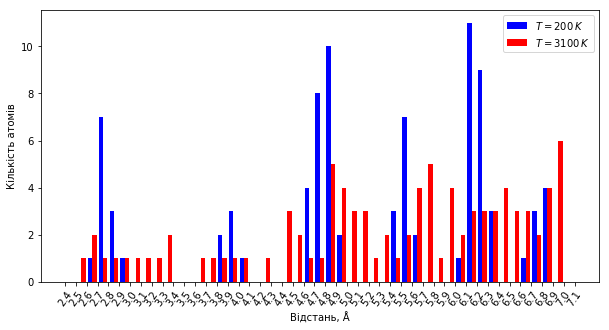

In [37]:
distances = [xyz[i].distance[(xyz[i].distance < 7) & (xyz[i].distance > 2.5)] for i in range(2)]
labels = [f'$T = {T[i]:.0f}\,K$' for i in range(2)]
plt.subplots(figsize=(10, 5))
bins = np.arange(2.4, 7.15, 0.1)
plt.hist(distances, bins=bins, label=labels, color=['blue', 'red'])

plt.legend()
plt.xticks(bins, rotation=55)
plt.xlabel('Відстань, Å')
plt.ylabel('Кількість атомів')
plt.show()

- Побудувати ФРРА за формулами

$$\rho = \frac{dn}{4\pi r^2\, dr}$$

та

$$g(r) = \frac{V}{N} \rho(r) = \frac{1}{\rho_{\textit{ат}}} \rho(r)$$

Величини $dn$ взяти з попереднього пункту, як і $dr=0.1\,A$.

In [39]:
dn = [np.histogram(d, bins=bins)[0] for d in distances]

factor = 1.0 / (4 * np.pi * 0.1)
V = 4/3 * np.pi * (7)**3
N = [i.sum() for i in dn]
r = bins[:-1]

g = [V/N[i] * factor * dn[i] / (r**2) for i in range(2)]

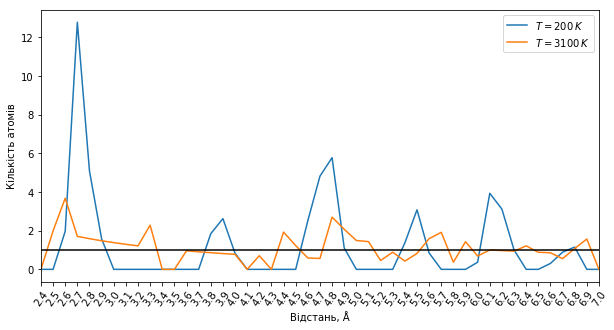

In [40]:
plt.subplots(figsize=(10, 5))
plt.plot(r, g[0], r, g[1])
plt.plot([0, 7], [1, 1], color='black')
plt.xlim((2.4, 7))
plt.xticks(r, rotation=55)
plt.legend(labels)
plt.xlabel('Відстань, Å')
plt.ylabel('Кількість атомів')
plt.show()

 - Знайти координаційні числа для кристалу і рідини в трьох перших координаційних сферах.

Для кристалу:

In [47]:
n = np.array([s for s in [sum(arr) for arr in np.split(dn[0], np.where(dn[0] == 0)[0])] if s != 0.0][:3])
n

array([12,  6, 24])

Для рідини:

In [9]:
dn[1] = np.where(np.round(r, 1)==5.3, 0, dn[1])
[s for s in [sum(arr) for arr in np.split(dn[1], np.where(dn[1] == 0)[0])] if s != 0.0][:4]

[11, 5, 1, 23]

Координаційні числа:

|# коорд. сфери| кристал| рідина|
|--------------|------|------|
|1             |12|11|
|2             |6|5|
|3             |24|24|

- Знайти відстані до атомів в цих сферах.

Для кристалу:

In [10]:
rdf[0].index[find_peaks_cwt(rdf[0]['count'], rdf[0].index)][:3]

Float64Index([2.77, 3.92, 4.78], dtype='float64', name='X')

Для рідини:

In [11]:
Rostyslav Bohomazrdf[1].index[find_peaks_cwt(rdf[1]['count'], rdf[1].index)][:3]

Float64Index([2.73, 3.88, 4.78], dtype='float64', name='X')

Відстані до цих координаційних сфер:

|# коорд. сфери| кристал, Å|рідина, Å|
|--------------|------------|---|
|1             | 2.77       |2.73|
|2             | 3.92       |3.88|
|3             | 4.78       |4.78|

Порівняти щільність пакування атомів в різних типах ґраток і рідині, та їх густину.

In [81]:
scale = 3.9231
Rion = scale * np.sqrt(2) / 4
Vion = 4/3 * np.pi * Rion ** 3
Latex(r'$R_{ion} = %.2f\,Å \\ V_{ion} = %.2f\,Å^3$' % (Rion, Vion))

<IPython.core.display.Latex object>

In [59]:
pack = pd.DataFrame({'R':[3.4, 4.2, 5.1]})
pack['V'] = 4/3 * np.pi * pack['R'] ** 3
pack['N'] = n.cumsum() + 1
pack['C'] = pack['N'] * Vion / pack['V'] * 100
pack

<IPython.core.display.Latex object>


,R,V,N,C
0,3.4,164.636210,13,88.259153
1,4.2,310.339089,19,68.431945
2,5.1,555.647209,43,86.498999


Пояснити, як узгоджуються ФРР і розташування дифракційних ліній на рентгенограмах.

![](./img/xray-diagram.png)